In [1]:
import os

os.chdir('/home/hyunjun/workspace/backtester')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

In [ ]:
universe = pd.read_csv('data/price.csv', index_col=0)

In [8]:
from typing import List
from typing import Tuple
from typing import Iterable

class Portfolio:
    def __init__(self, ticker:Iterable[str], weight:Iterable[float]):
        self.ticker = np.array(ticker)
        self.weight = np.array(self.__con(weight))
        self.dict = self.__get_dict()
    
    def update_weight(self, weight:Iterable[float]):
        self.weight = np.array(self.__con(weight))
        self.dict = self.__get_dict()

    def update_ticker(self, ticker:Iterable[str]):
        self.ticker = np.array(ticker)
        self.dict = self.__get_dict()

    def __repr__(self) -> str:
        return f"{self.dict}"

    def __len__(self) -> int:
        return len(self.dict)

    def __get_dict(self) -> dict:
        return dict(zip(self.ticker, self.weight))
    
    def __con(self, w):
        if np.sum(w, dtype=np.float16) != 1.0:
            raise Exception('Sum to One Error')
        return w 
    
class Order: 
    def __init__(self):
        self.ticker = np.array([])
        self.size = np.array([]) 
        self.dict = self.__get_dict()

    def append(self, ticker:Iterable[str], size:Iterable[float]):
        self.ticker = np.append(self.ticker, ticker)
        self.size = np.append(self.size, size)
        self.dict = self.__get_dict()

    def __repr__(self) -> str:
        return f"{self.dict}"
    
    def __get_dict(self) -> dict:
        return dict(zip(self.ticker, self.size))

### Line By Line

In [546]:
balance = np.float64(1000000)
portfolio_value = np.float64(1000000)

In [547]:
# 첫달 전량 매수 order

balance = np.float64(0)

p_old = Portfolio(['A', 'B', 'C', 'D', 'E'], [1/5, 1/5, 1/5, 1/5, 1/5])
p_old

{'A': 0.2, 'B': 0.2, 'C': 0.2, 'D': 0.2, 'E': 0.2}

In [548]:
# 두번째달 가격 변동으로 인한 포트폴리오 변화

price_old = universe.loc['1980-12-31', p_old.ticker].values
price_now = universe.loc['1981-01-31', p_old.ticker].values

returns = np.float64((price_now - price_old) / price_old)
returns = np.where(np.isnan(returns), np.float64(-0.99), returns)

changed_weight = p_old.weight * (1 + returns) / np.sum(p_old.weight * (1 + returns))

p_old.update_weight(changed_weight)
p_old

{'A': 0.20244018254340124, 'B': 0.1906886851515448, 'C': 0.20711487908014553, 'D': 0.18906248383490354, 'E': 0.21069376939000492}

In [549]:
# 두번째달 가격 변동으로 인한 포트폴리오 평가금액, 수익률 계산

pv = np.dot(portfolio_value * p_old.weight, 1 + returns)
pf = ((pv / 1000000) -1) * 100

pv, pf

(952014.4022564272, -4.7985597743572805)

In [550]:
# 두번째달, 달라진 포트폴리오 종목

p_new = Portfolio(['A', 'F', 'C', 'D', 'E'], [1/5, 1/5, 1/5, 1/5, 1/5]) 
p_new

{'A': 0.2, 'F': 0.2, 'C': 0.2, 'D': 0.2, 'E': 0.2}

In [551]:
# Gap 계산 대상
gap_ticker = p_old.ticker[np.isin(p_old.ticker, p_new.ticker)] 

# Gap 사이즈
gap_size = p_new.weight[np.isin(p_old.ticker, p_new.ticker)] - \
    p_old.weight[np.isin(p_old.ticker, p_new.ticker)]

# 매도 대상
sell_ticker = p_old.ticker[~ np.isin(p_old.ticker, p_new.ticker)]

# 매도 대상 사이즈
sell_size = -p_old.weight[~ np.isin(p_old.ticker, p_new.ticker)]

# 매수 대상
buy_ticker = p_new.ticker[~ np.isin(p_new.ticker, p_old.ticker)]

# 매수 대상 사이즈
buy_size = p_new.weight[~ np.isin(p_new.ticker, p_old.ticker)]

In [552]:
# 거래해야할 비중 계산하기

order = Order()

gap_order = (gap_ticker, gap_size)
sell_order = (sell_ticker, sell_size)
buy_order = (buy_ticker, buy_size)

order.append(*gap_order)
order.append(*sell_order)
order.append(*buy_order)

order

{'A': -0.002440182543401226, 'C': -0.00711487908014552, 'D': 0.010937516165096473, 'E': -0.010693769390004909, 'B': -0.1906886851515448, 'F': 0.2}

In [553]:
# 보유하고 있는 종목과 보유할 종목을 combine 해놓기

combine = {}.fromkeys(order.ticker, 0.0)
combine.update(p_old.dict)

weight = np.fromiter(combine.values(), dtype=np.float64)
combine

{'A': 0.20244018254340124,
 'C': 0.20711487908014553,
 'D': 0.18906248383490354,
 'E': 0.21069376939000492,
 'B': 0.1906886851515448,
 'F': 0.0}

In [554]:
closing_price = universe.loc['1981-01-31', order.ticker].values
closing_price

array([1388.,  939., 3499., 6801.,  234., 1170.])

In [555]:
"""
주문 집행

(1) 매도 주문의 경우 잔량 없이 종가에 체결된다고 가정
(2) 매수 주문의 경우 잔고가 없는 경우에는 체결이 안될 수 있음
(3) 매수 주문의 경우 잔고에 각 매수 종목의 매수 금액 비율을 곱하여 매수 가능 금액 계산
"""
CHARGE = 0.001 #0.001
TEX = 0.0025 #0.0025
FEE = 0.0

sell_cost = CHARGE + TEX
buy_cost = CHARGE

action = order.size

# 매도 주문부터
sell_ind = np.where( (action < 0) )[0]
weight[sell_ind] += action[sell_ind]
sell_moneys = portfolio_value * abs(action[sell_ind]) * (1.0-sell_cost)
sell_amount = np.sum(sell_moneys) 
balance += sell_amount
FEE += sell_amount * sell_cost

# 매수 주문 처리
buy_ind = np.where( (action > 0) )[0]
buy_moneys = portfolio_value * action[buy_ind] * (1.0+buy_cost)
buy_amount = np.sum(buy_moneys) 

allocation = buy_moneys / buy_amount

buy_fee = balance * (buy_cost/(1+buy_cost)) 
feasible_buy_moneys = (balance - buy_fee) * allocation 
feasible_buy_amount = np.sum(feasible_buy_moneys)
feasible_buy_action = feasible_buy_moneys / portfolio_value
FEE += feasible_buy_amount * buy_cost # (= buy_fee)

weight[buy_ind] += feasible_buy_action
weight = weight / np.sum(weight)

portfolio_value -= FEE
balance -= feasible_buy_amount 

In [556]:
# 거래 후 비중이 0보다 큰 (보유하고 있는) 종목만 모아서 새로운 포트폴리오로 업데이트

p_old = Portfolio(order.ticker[weight>0], weight[weight>0])

In [557]:
p_old

{'A': 0.20018983412454824, 'C': 0.20018983412454824, 'D': 0.20014061780106815, 'E': 0.20018983412454824, 'F': 0.19928987982528704}

### Loop
- 종목선택 함수만 끼우면 백테스팅 가능

In [12]:
init_balance = 1000000
portfolio_value = init_balance
profitloss = 0
balance = 0

p_old = Portfolio(['A', 'B', 'C', 'D', 'E', 'K'], 
                  [1/6, 1/6, 1/6, 1/6, 1/6, 1/6])

price_old = universe.iloc[0][p_old.ticker].values

PVs = []
PFs = []
POs = []

for i in range(1, 400):
    POs.append(p_old.weight)
    
    # 여기는 get_price 함수로 (인자는 ticker 받도록)
    price_old = universe.iloc[i-1][p_old.ticker].values
    price_now = universe.iloc[i][p_old.ticker].values

    # 다음 타임 스텝에서 가격 변동으로 인한 포트폴리오 변화
    ratio = (price_now - price_old) / price_old
    ratio = np.where(np.isnan(ratio), np.float64(-0.99), ratio)
    weight_now = p_old.weight * (1+ratio) 
    weight_now = weight_now / np.sum(weight_now)

    p_old.update_weight(weight_now)
    
    # 다음 타입 스텝에서 가격 변동으로 인한 포트폴리오 평가금액, 수익률 계산
    portfolio_value = np.dot(portfolio_value * p_old.weight, 1+ratio)
    profitloss = ((portfolio_value / init_balance) -1) * 100

    # Desired Portfolio
    p_new = Portfolio(['A', 'F', 'C', 'G', 'E', 'S'], 
                      [1/6, 1/6, 1/6, 1/6, 1/6, 1/6])

    """
    Order 계산
    """
    # Gap 계산 대상
    gap_ticker = p_old.ticker[np.isin(p_old.ticker, p_new.ticker)] 

    # Gap 사이즈
    gap_size = p_new.weight[np.isin(p_old.ticker, p_new.ticker)] - \
        p_old.weight[np.isin(p_old.ticker, p_new.ticker)]
    
    # 매도 대상
    sell_ticker = p_old.ticker[~ np.isin(p_old.ticker, p_new.ticker)]

    # 매도 대상 사이즈
    sell_size = -p_old.weight[~ np.isin(p_old.ticker, p_new.ticker)]

    # 매수 대상
    buy_ticker = p_new.ticker[~ np.isin(p_new.ticker, p_old.ticker)]

    # 매수 대상 사이즈
    buy_size = p_new.weight[~ np.isin(p_new.ticker, p_old.ticker)]

    # 오더
    order = Order()

    gap_order = (gap_ticker, gap_size)
    sell_order = (sell_ticker, sell_size)
    buy_order = (buy_ticker, buy_size)

    order.append(*gap_order)
    order.append(*sell_order)
    order.append(*buy_order)
        
    # 보유하고 있는 종목과 보유할 종목을 combine 해놓기
    combine = {}.fromkeys(order.ticker, 0.0)
    combine.update(p_old.dict)
    weight = np.fromiter(combine.values(), dtype=np.float64)
    
    closing_price_all = universe.iloc[i][order.ticker].values

    """
    주문 집행
    """
    CHARGE = 0.00 #0.001
    TEX = 0.00 #0.0025
    FEE = 0.0

    sell_cost = CHARGE + TEX
    buy_cost = CHARGE

    action = order.size

    # 매도 주문부터
    sell_ind = np.where( (action < 0) )[0]
    weight[sell_ind] += action[sell_ind]
    sell_moneys = portfolio_value * abs(action[sell_ind]) * (1.0-sell_cost)
    sell_amount = np.sum(sell_moneys) 
    balance += sell_amount
    FEE += sell_amount * sell_cost

    # 매수 주문 처리
    buy_ind = np.where( (action > 0) )[0]
    buy_moneys = portfolio_value * action[buy_ind] * (1.0+buy_cost)
    buy_amount = np.sum(buy_moneys) 

    allocation = buy_moneys / buy_amount

    buy_fee = balance * (buy_cost/(1+buy_cost)) 
    feasible_buy_moneys = (balance - buy_fee) * allocation 
    feasible_buy_amount = np.sum(feasible_buy_moneys)
    feasible_buy_action = feasible_buy_moneys / portfolio_value
    FEE += feasible_buy_amount * buy_cost # (= buy_fee)

    weight[buy_ind] += feasible_buy_action
    weight = weight / np.sum(weight)

    portfolio_value -= FEE
    balance -= feasible_buy_amount 

    p_old = Portfolio(order.ticker[weight>0], weight[weight>0])

    PVs.append(portfolio_value)
    PFs.append(profitloss)

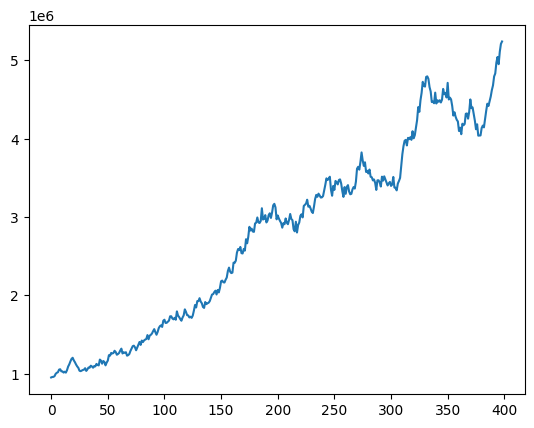

In [13]:
plt.plot(PVs)

In [11]:
pd.DataFrame(POs)

,0,1,2,3,4,5
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
2,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
4,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
...,...,...,...,...,...,...
394,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
395,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
396,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
397,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
